### Paquetes

In [50]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from tqdm import tqdm as tq
import json
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unicodedata
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import os

In [51]:
dff = pd.read_excel("5_DBF_SHORT.xlsx")

In [52]:
dff["year"] = dff["dc.date.issued"].apply(lambda x: str(x)[0:4] if pd.notnull(x) and len(str(x)) > 3 else np.nan)


In [94]:
# nombre_carpeta = "ABSTRACT"
# nombre_carpeta = "CONTENIDO"
nombre_carpeta = "TITULO"

ruta_carpeta = "./" + nombre_carpeta
if not os.path.exists(ruta_carpeta):
    os.makedirs(ruta_carpeta)

In [95]:
dff["abstract"] = dff["dc.description.abstract"].astype(str)
dff["contenido_c"] = dff["contenido"].astype(str)
dff["title"] = dff["dc.title"].astype(str)

In [96]:
if nombre_carpeta == "ABSTRACT":
    variable = "abstract"

if nombre_carpeta == "CONTENIDO":
    variable = "contenido_c"

if nombre_carpeta == "TITULO":
    variable = "title"

In [97]:
df = dff.copy()
df = df[[variable, "year"]]

### Limpieza

In [98]:
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúñü\s]', '', texto)
    texto = unicodedata.normalize('NFKD', texto).encode('ascii', 'ignore').decode('utf-8')

    return texto



def eliminar_stopwords(texto):
    palabras = texto.split()
    palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words]
    return ' '.join(palabras_filtradas)

def eliminar_palabras(texto, palabras_a_eliminar):
    palabras = texto.split()  # Divide el texto en palabras
    palabras_filtradas = [palabra for palabra in palabras if palabra not in palabras_a_eliminar]
    texto_filtrado = ' '.join(palabras_filtradas)  # Une las palabras filtradas en una cadena
    return texto_filtrado


palabras_a_eliminar = ['instituto', 'humboldt', 'corporacion', 'autonoma', 'realizo', 'metodologia', 'fin', 
                       'diferentes', 'bajo', 'estrategia', 'traves', 'dos', 'dentro', 'total', 'embargo', 
                       'referencia', 'estudios', 'uso', 'fondo', 'tecnicos', 'economicos', 'tres', 
                       'importante', 'ejecucion', 'contrato', 'asi', 'toma', 'decisiones', 'firmado', 
                       'presenta', 'complejo', 'von', 'alezander', 'convenio', 'et', 'parte', 'partir', 
                       'cada', 'ano', 'gran', 'linea', 'base', 'contiene', 'presente', 'documento', 'et', 
                       'parte', 'partir', 'cada', 'ano', 'gran', 'linea', 'base', 'contiene', 'presente', 
                       'documento', 'marco', 'producto', 'ps', 'caso', 'mayor', 'tipo', 'ce', 'mas',
                       "mismo", "resultado", "tambien", "ademas", "cuales", "elemento", "posible", "si",
                       "cuales", "pai", "b", "segun", "vez", "hace", "si", "c", "n",
                       "tabla", "no", "figura", "alexander", " investigacion"]




def limpieza(texto):
    t = limpiar_texto(texto)
    t = eliminar_stopwords(t)
    t = eliminar_palabras(t, palabras_a_eliminar)
    return t


In [99]:
df[variable] = df[variable].apply(lambda x: limpieza(x))

### Frecuencia

#### General

Nube de palabras

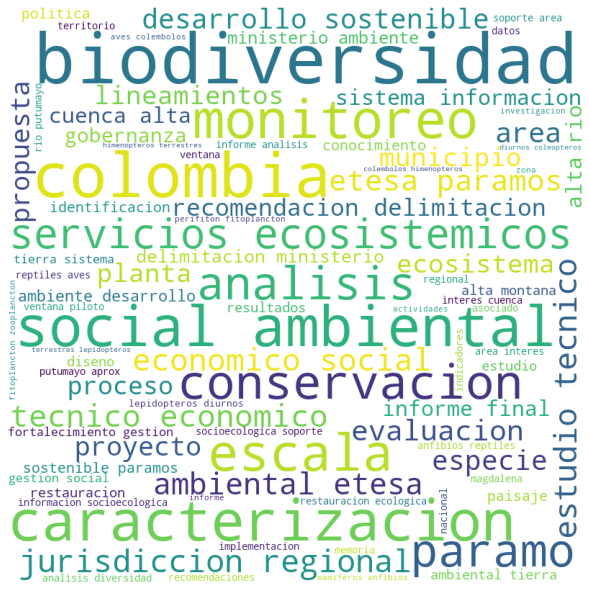

In [100]:
# Concatena todo el texto de la columna 'texto' en una sola cadena
texto_completo = ' '.join(df[variable].astype(str))

altura, anchura = 800, 800
# Configuración de la nube de palabras
wordcloud = WordCloud(width = altura, height = anchura, 
                      background_color ='white', 
                      min_font_size = 10).generate(texto_completo)

# Configuración de la figura para mostrar la nube de palabras
plt.figure(figsize = (altura/100, anchura/100), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Mostrar la nube de palabras
plt.savefig(ruta_carpeta+"/0_NUBE.jpeg", dpi=300, bbox_inches='tight')
plt.show()


Histograma de frecuencias

<ipython-input-101-9f134ff0a51f>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_frecuencias = df_frecuencias.append({'Termino': termino, 'Frecuencia': frecuencia_termino}, ignore_index=True)
<ipython-input-101-9f134ff0a51f>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_frecuencias = df_frecuencias.append({'Termino': termino, 'Frecuencia': frecuencia_termino}, ignore_index=True)


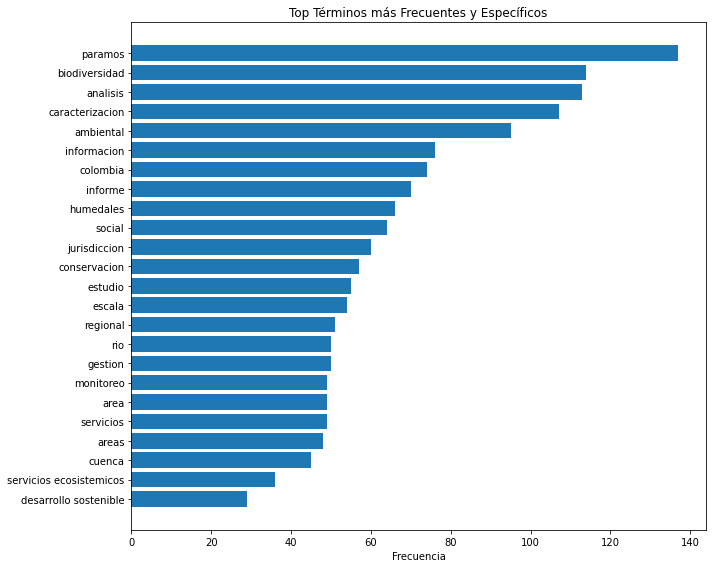

In [101]:
texto_completo = ' '.join(df[variable].astype(str)).lower()
palabras = texto_completo.split()
frecuencias = Counter(palabras)
df_frecuencias = pd.DataFrame(frecuencias.most_common(22), columns=['Termino', 'Frecuencia'])

terminos_especificos = ['desarrollo sostenible', 'servicios ecosistemicos']
for termino in terminos_especificos:
    frecuencia_termino = texto_completo.count(termino)
    if termino not in df_frecuencias['Termino'].values:
        df_frecuencias = df_frecuencias.append({'Termino': termino, 'Frecuencia': frecuencia_termino}, ignore_index=True)

df_frecuencias = df_frecuencias.sort_values(by='Frecuencia', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(df_frecuencias['Termino'], df_frecuencias['Frecuencia'])
plt.xlabel('Frecuencia')
plt.title('Top Términos más Frecuentes y Específicos')
plt.tight_layout()
plt.savefig(ruta_carpeta+"/1_FRECUENCIA.jpeg", dpi=300, bbox_inches='tight')
plt.show()


Heatmap en niveles

In [102]:
# Supongamos que este es tu DataFrame inicial
# df = ...

# Lista de términos para los cuales quieres calcular la frecuencia por año
terminos_interes = df_frecuencias['Termino'].tolist()

# Encuentra los años únicos presentes en el DataFrame
years = df['year'].dropna().unique()


# Prepara un DataFrame vacío para almacenar las frecuencias por año
df_frecuencias_anuales = pd.DataFrame(index=terminos_interes, columns=years).fillna(0)

for year in years:
    # Filtra el DataFrame por el año actual en el loop
    df_temp = df[df['year'] == year]
    
    # Concatena todos los abstracts de ese año en una sola cadena y convierte a minúsculas
    texto_anual = ' '.join(df_temp[variable].astype(str)).lower()
    
    # Calcula la frecuencia de cada término de interés en ese año
    for termino in terminos_interes:
        frecuencia_termino = texto_anual.count(termino)
        df_frecuencias_anuales.loc[termino, year] = frecuencia_termino



In [103]:
df_frecuencias_anuales = df_frecuencias_anuales.sort_values(by = ["2022"], ascending=False)

In [104]:
colores = ["#FF0000", "#FF7F00", "#FFFF00", "#7FFF00", "#00FF00", 
           "#00FF7F", "#00FFFF", "#007FFF", "#0000FF", "#7F00FF", 
           "#FF00FF", "#FF007F", "#FF0000"]  # Nota el retorno al primer color para cerrar el ciclo



In [105]:
import matplotlib.colors as mcolors
import numpy as np

# Genera 12 colores de la paleta 'twilight', más uno para cerrar el ciclo
colores = plt.cm.twilight(np.linspace(0, 1, 13))

# Convierte los colores RGBA a formato hexadecimal
colores_hex = [mcolors.rgb2hex(color) for color in colores]


colores_hex[-1] = "#FF00FF" 
colores_hex[-1] = "#FFB6C1"

from matplotlib.colors import LinearSegmentedColormap

# Crea la paleta cíclica continua
paleta_ciclica = LinearSegmentedColormap.from_list("mi_paleta_ciclica", colores_hex)

In [106]:
paleta = "twilight"
paleta = paleta_ciclica

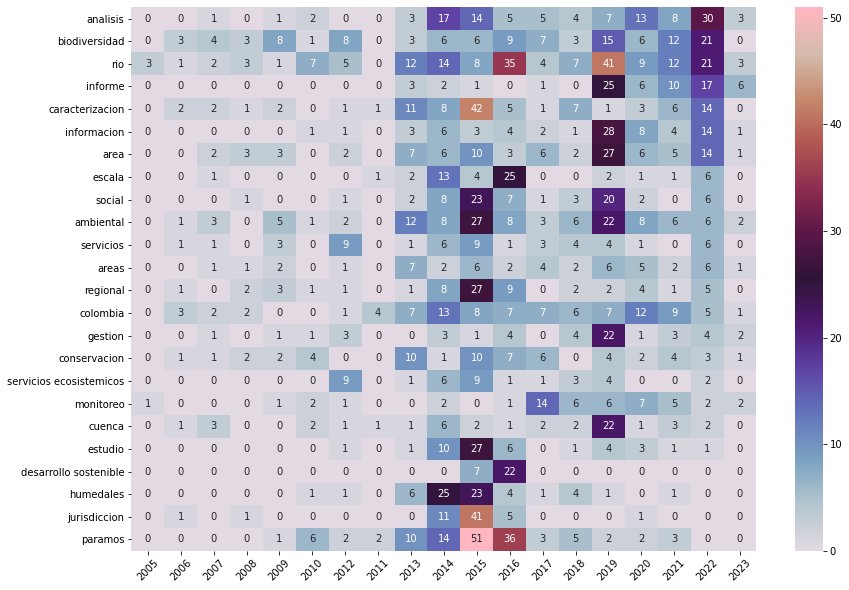

In [107]:
import seaborn as sns

plt.figure(figsize=(14, 10))
# sns.heatmap(df_frecuencias_anuales, cmap=paleta_ciclica, annot=True, fmt='g')
sns.heatmap(df_frecuencias_anuales, cmap=paleta, annot=True, fmt='g')

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.savefig(ruta_carpeta+"/2_HEAT_NIVELES.jpeg", dpi=300, bbox_inches='tight')

plt.show()


Heatmap por año

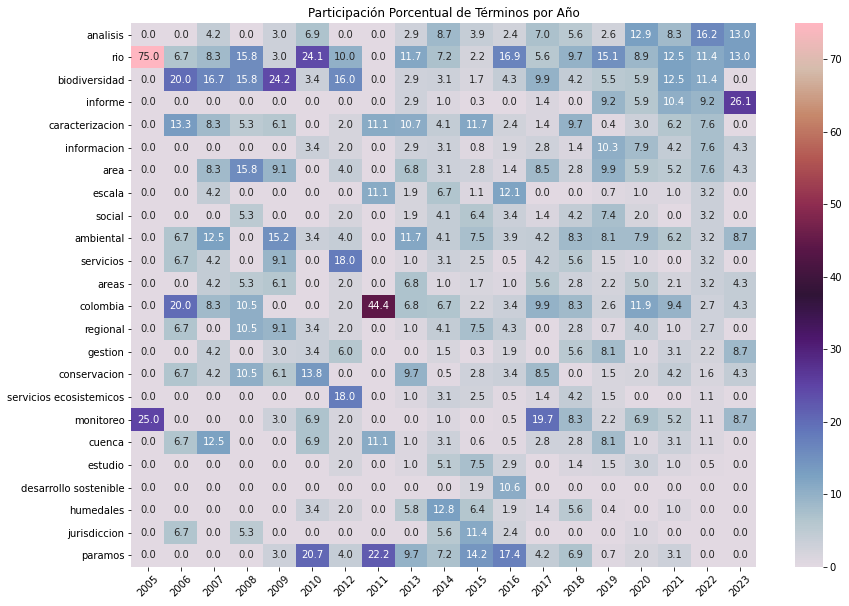

In [108]:
# Calcula el total de frecuencias por año
total_frecuencias_por_año = df_frecuencias_anuales.sum()

# Calcula la participación porcentual de cada término por año
df_porcentaje_anual = df_frecuencias_anuales.divide(total_frecuencias_por_año) * 100


plt.figure(figsize=(14, 10))
sns.heatmap(df_porcentaje_anual.sort_values(by = ["2022"], ascending=False), cmap=paleta, annot=True, fmt=".1f")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Participación Porcentual de Términos por Año")
plt.savefig(ruta_carpeta+"/3_HEAT_PORCENTAJE_AÑO_NIVEL.jpeg", dpi=300, bbox_inches='tight')
plt.show()


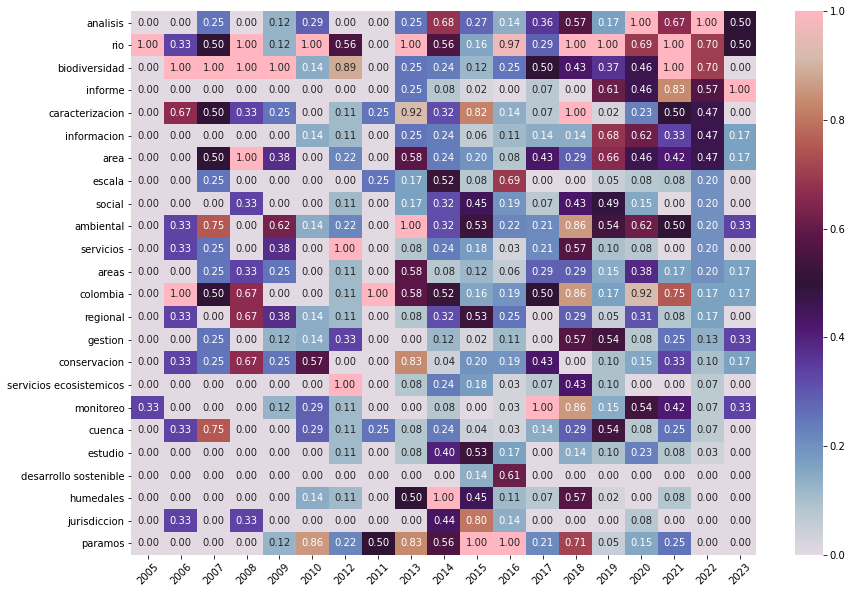

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Asumiendo que df_frecuencias_anuales ya está creado y contiene las frecuencias por año

# Normaliza los datos por columna (año)
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_frecuencias_anuales), columns=df_frecuencias_anuales.columns, index=df_frecuencias_anuales.index)

# Ahora, plotea el heatmap con los datos normalizados
plt.figure(figsize=(14, 10))
sns.heatmap(df_normalized.sort_values(by = ["2022"], ascending=False), cmap=paleta, annot=True, fmt=".2f")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig(ruta_carpeta+"/4_HEAT_PORCENTAJE_AÑO_INDICE.jpeg", dpi=300, bbox_inches='tight')

plt.show()


Heatmaps por variable

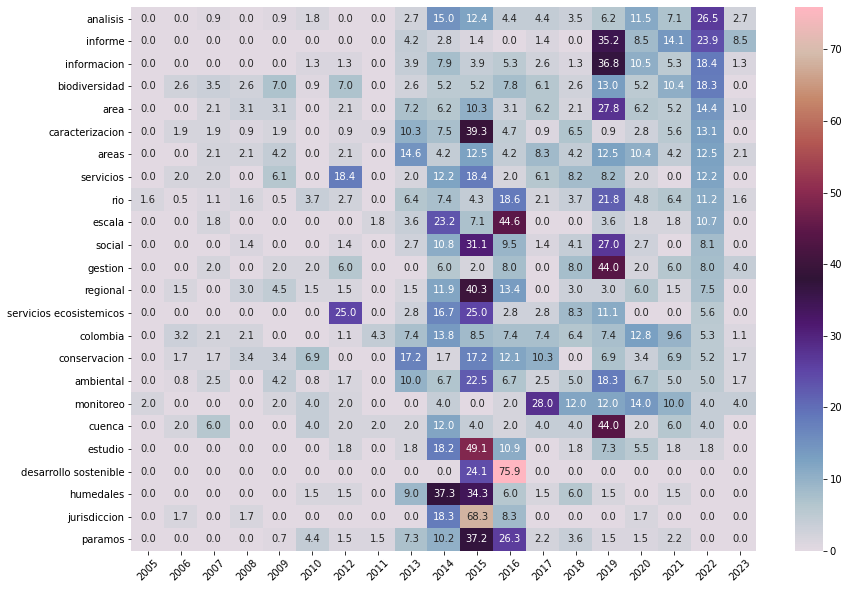

In [110]:
# Calcula el total de frecuencias por año
total_frecuencias_por_año = df_frecuencias_anuales.T.sum()

# Calcula la participación porcentual de cada término por año
df_porcentaje_anual = (df_frecuencias_anuales.T.divide(total_frecuencias_por_año) * 100).T

plt.figure(figsize=(14, 10))
sns.heatmap(df_porcentaje_anual.sort_values(by = ["2022"], ascending=False), cmap=paleta, annot=True, fmt=".1f")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig(ruta_carpeta+"/5_HEAT_PORCENTAJE_VARIABLE_NIVEL.jpeg", dpi=300, bbox_inches='tight')

plt.show()

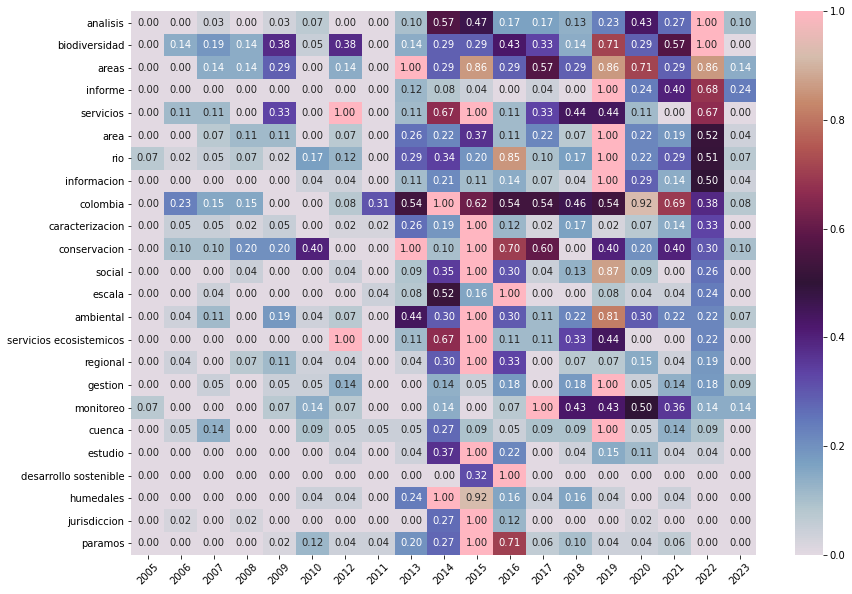

In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Asumiendo que df_frecuencias_anuales ya está creado y contiene las frecuencias por año

# Normaliza los datos por columna (año)
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_frecuencias_anuales.T).T, columns=df_frecuencias_anuales.columns, index=df_frecuencias_anuales.index)

# Ahora, plotea el heatmap con los datos normalizados
plt.figure(figsize=(14, 10))
sns.heatmap(df_normalized.sort_values(by = ["2022"], ascending=False), cmap=paleta, annot=True, fmt=".2f")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig(ruta_carpeta+"/6_HEAT_PORCENTAJE_VARIABLE_INDICE.jpeg", dpi=300, bbox_inches='tight')

plt.show()


### LDA

Paquetes

In [112]:
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.tokenize import word_tokenize

rs = 6423

Limpieza

In [113]:
# Asumiendo que df es tu DataFrame y "abstract" la columna con el texto
# Preprocesamiento: tokenización y eliminación de stopwords
texts = df[variable].map(lambda x: [word for word in word_tokenize(x.lower()) if word not in STOPWORDS])

# Crea un diccionario y corpus para LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


Optimización

In [85]:
# Número inicial de tópicos
num_topics = 5
lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

In [138]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state = rs)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Determinar el rango de número de tópicos a explorar
limit=20; start=2; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=start, limit=limit, step=step)


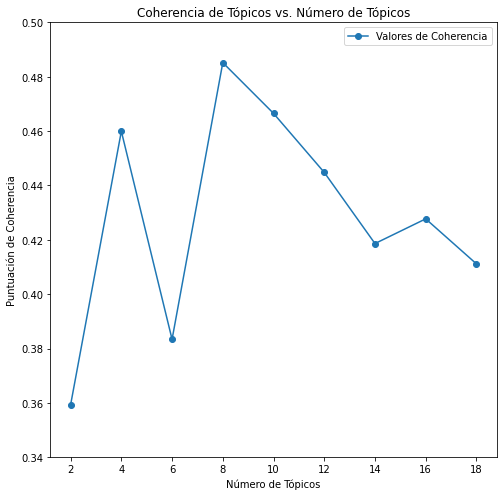

In [142]:
import matplotlib.pyplot as plt

# Asume que 'start', 'limit', 'step', y 'coherence_values' están definidos
x = range(start, limit, step)

# Configura el tamaño de la figura a 8x8 pulgadas
plt.figure(figsize=(8, 8))

# Crea la gráfica
plt.plot(x, coherence_values, marker='o')

# Establece los límites en el eje y
plt.ylim(0.34, 0.50)

# Añade etiquetas y título
plt.xlabel("Número de Tópicos")
plt.ylabel("Puntuación de Coherencia")
plt.title("Coherencia de Tópicos vs. Número de Tópicos")

# Añade una leyenda
plt.legend(["Valores de Coherencia"], loc='best')

# Muestra la gráfica
plt.savefig(ruta_carpeta+"/7_OPTIMIZACIÓN_LDA.jpeg", dpi=300, bbox_inches='tight')
plt.show()


Modelo final

In [114]:
# Número inicial de tópicos
# Establecer la semilla aleatoria para garantizar la replicabilidad
random_state = rs

if variable == "abstract":
    num_topics = 12

if variable == "title":
    num_topics = 8

if variable == "contenido_c":
    num_topics = 10



lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=random_state)

Tabla con resultados

In [115]:
topicos_palabras = lda.print_topics(num_words=10)
for topic in topicos_palabras:
    print(topic)

(0, '0.027*"restauracion" + 0.015*"biodiversidad" + 0.013*"ecologica" + 0.012*"herramientas" + 0.012*"politica" + 0.011*"gestion" + 0.010*"lineamientos" + 0.010*"nacional" + 0.010*"paisaje" + 0.010*"procesos"')
(1, '0.027*"biodiversidad" + 0.013*"paramo" + 0.011*"ecosistemas" + 0.010*"plan" + 0.010*"conocimiento" + 0.010*"regionales" + 0.008*"investigacion" + 0.007*"indigenas" + 0.007*"desarrollo" + 0.007*"cuenca"')
(2, '0.021*"biodiversidad" + 0.021*"paramos" + 0.019*"areas" + 0.015*"conservacion" + 0.013*"colombia" + 0.012*"memorias" + 0.009*"biotica" + 0.009*"humedales" + 0.008*"intercambio" + 0.008*"ventana"')
(3, '0.017*"piloto" + 0.015*"cienaga" + 0.013*"analisis" + 0.012*"caracterizacion" + 0.011*"monitoreo" + 0.011*"san" + 0.011*"humedales" + 0.011*"servicios" + 0.009*"especies" + 0.009*"ambientales"')
(4, '0.055*"paramos" + 0.033*"jurisdiccion" + 0.025*"regional" + 0.023*"caracterizacion" + 0.022*"ambiental" + 0.022*"social" + 0.021*"tecnico" + 0.021*"delimitacion" + 0.021*"es

In [116]:
if variable == "abstract":

    nombres_temas = [
    'Análisis de biodiversidad y gestión',
    'Caracterización de páramos y adaptación',
    'Diversidad acuática y muestreo',
    'Especies y valor ecosistémico',
    'Gobernanza y proyectos de páramos',
    'Información para conservación',
    'Servicios ecosistémicos y investigación',
    'Impacto ambiental y especies',
    'Gestión y conservación ambiental',
    'Desarrollo y biodiversidad nacional',
    'Planificación regional y páramos',
    'Educación y monitoreo de biodiversidad'
]
    

if variable == "title":

    nombres_temas = [
    'Restauración ecológica y política',
    'Biodiversidad en páramos y planificación',
    'Memorias y áreas de conservación',
    'Pilotos de caracterización y monitoreo',
    'Jurisdicción y estudios regionales',
    'Información cuenca y gestión ambiental',
    'Identificación y conservación de humedales',
    'Diversidad de fauna terrestre'
]
    

if variable == "contenido_c":
    nombres_temas = [ 'Muestreo acuático y especies',
    'Áreas de conservación y servicios',
    'Ríos, páramos y ecosistemas',
    'Desarrollo ambiental y sostenibilidad',
    'Flora silvestre y proyectos',
    'Entornos regionales y biodiversidad',
    'Conservación de páramos y biodiversidad',
    'Datos y humedales',
    'Diversidad forestal y conservación',
    'Restauración vegetal y biodiversidad'
]


In [117]:
# Crear un DataFrame para almacenar los resultados
df_topicos_palabras = pd.DataFrame(columns=['topico', 'Palabras'])

# Iterar sobre los resultados y agregarlos al DataFrame
for t, palabras in topicos_palabras:
    df_topicos_palabras = df_topicos_palabras.append({'topico': t, 'Palabras': palabras}, ignore_index=True)

# Reemplazar '*' por 'x' y eliminar comillas
df_topicos_palabras['ecuacion'] = df_topicos_palabras['Palabras'].str.replace('*', ' X').str.replace('"', ' ')

# Crear una nueva columna con solo las palabras separadas por comas
df_topicos_palabras['palabras'] = df_topicos_palabras['ecuacion'].str.replace('[^a-zA-Z\s]', '').str.replace('X', ',').str.strip()
df_topicos_palabras['palabras'] = df_topicos_palabras['palabras'].apply(lambda x: x[2:])

df_topicos_palabras = df_topicos_palabras[["topico", "palabras", "ecuacion"]]

<>:12: DeprecationWarning: invalid escape sequence \s
<>:12: DeprecationWarning: invalid escape sequence \s
<ipython-input-117-d14c89d8954b>:12: DeprecationWarning: invalid escape sequence \s
  df_topicos_palabras['palabras'] = df_topicos_palabras['ecuacion'].str.replace('[^a-zA-Z\s]', '').str.replace('X', ',').str.strip()
<ipython-input-117-d14c89d8954b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_topicos_palabras = df_topicos_palabras.append({'topico': t, 'Palabras': palabras}, ignore_index=True)
<ipython-input-117-d14c89d8954b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_topicos_palabras = df_topicos_palabras.append({'topico': t, 'Palabras': palabras}, ignore_index=True)
<ipython-input-117-d14c89d8954b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

In [118]:
df_topicos_palabras["tema"] = nombres_temas
df_topicos_palabras

,topico,palabras,ecuacion,tema
0,0,"restauracion , biodiversidad , ecologica...",0.027 X restauracion + 0.015 X biodiversidad ...,Restauración ecológica y política
1,1,"biodiversidad , paramo , ecosistemas ...",0.027 X biodiversidad + 0.013 X paramo + 0.0...,Biodiversidad en páramos y planificación
2,2,"biodiversidad , paramos , areas , con...",0.021 X biodiversidad + 0.021 X paramos + 0....,Memorias y áreas de conservación
3,3,"piloto , cienaga , analisis , caracte...",0.017 X piloto + 0.015 X cienaga + 0.013 X a...,Pilotos de caracterización y monitoreo
4,4,"paramos , jurisdiccion , regional , c...",0.055 X paramos + 0.033 X jurisdiccion + 0.0...,Jurisdicción y estudios regionales
5,5,"informacion , ambiental , rio , cuenc...",0.022 X informacion + 0.020 X ambiental + 0....,Información cuenca y gestión ambiental
6,6,"identificacion , humedales , colombia ...",0.025 X identificacion + 0.021 X humedales +...,Identificación y conservación de humedales
7,7,"aves , mamiferos , terrestres , infor...",0.023 X aves + 0.021 X mamiferos + 0.021 X t...,Diversidad de fauna terrestre


Visualización html

In [119]:
import pyLDAvis
import pyLDAvis.gensim  # Asegúrate de estar utilizando la versión correcta de pyLDAvis

# Suponiendo que `lda`, `corpus`, y `dictionary` son tu modelo LDA, corpus y diccionario de Gensim, respectivamente

# Crear la visualización de LDA con pyLDAvis
lda_visualization = pyLDAvis.gensim.prepare(lda, corpus, dictionary)

# Guardar la visualización en un archivo HTML para visualizar en un navegador
pyLDAvis.save_html(lda_visualization, f'{ruta_carpeta}/VISUALIZACION_{variable}.html')

c:\Users\War\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


Asignar tema

In [120]:
# Crear una función para asignar el tópico más probable a un texto dado
def asignar_topico(texto):
    # Tokenizar y eliminar stopwords
    palabras = [word for word in word_tokenize(texto.lower()) if word not in STOPWORDS]
    # Convertir el texto en un bag of words
    bow = dictionary.doc2bow(palabras)
    # Obtener la distribución de tópicos para el texto dado
    distribucion_topicos = lda.get_document_topics(bow)
    # Ordenar los tópicos por probabilidad y devolver el más probable
    topico_mas_probable = sorted(distribucion_topicos, key=lambda x: x[1], reverse=True)[0][0]
    return topico_mas_probable

# Asignar el tópico más probable a cada texto en la columna 'abstract' del DataFrame
df = df[[variable, "year"]]
df['topico'] = df[variable].apply(asignar_topico)

In [121]:
df = df.merge(df_topicos_palabras[["topico", "tema"]], "left","topico")

Exportar tabla

In [122]:
aparicion = (df.groupby("topico").count()/df.groupby("topico").count().sum()*100).reset_index()[["topico", "tema"]]; aparicion.columns = ["topico", "presencia"]
df_topicos_palabras = df_topicos_palabras.merge(aparicion, "left", "topico")
df_topicos_palabras.to_excel(f"{ruta_carpeta}/TABLA_{variable}.xlsx", index = False)
df_topicos_palabras

<ipython-input-122-f1a430eba6aa>:3: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  df_topicos_palabras.to_excel(f"{ruta_carpeta}/TABLA_{variable}.xlsx", index = False)


,topico,palabras,ecuacion,tema,presencia
0,0,"restauracion , biodiversidad , ecologica...",0.027 X restauracion + 0.015 X biodiversidad ...,Restauración ecológica y política,9.421265
1,1,"biodiversidad , paramo , ecosistemas ...",0.027 X biodiversidad + 0.013 X paramo + 0.0...,Biodiversidad en páramos y planificación,9.017497
2,2,"biodiversidad , paramos , areas , con...",0.021 X biodiversidad + 0.021 X paramos + 0....,Memorias y áreas de conservación,11.574697
3,3,"piloto , cienaga , analisis , caracte...",0.017 X piloto + 0.015 X cienaga + 0.013 X a...,Pilotos de caracterización y monitoreo,11.978466
4,4,"paramos , jurisdiccion , regional , c...",0.055 X paramos + 0.033 X jurisdiccion + 0.0...,Jurisdicción y estudios regionales,18.842530
5,5,"informacion , ambiental , rio , cuenc...",0.022 X informacion + 0.020 X ambiental + 0....,Información cuenca y gestión ambiental,18.977120
6,6,"identificacion , humedales , colombia ...",0.025 X identificacion + 0.021 X humedales +...,Identificación y conservación de humedales,12.920592
7,7,"aves , mamiferos , terrestres , infor...",0.023 X aves + 0.021 X mamiferos + 0.021 X t...,Diversidad de fauna terrestre,7.267833


Heatmaps

In [123]:
pivot = pd.pivot_table(df, values=variable, index='year', columns='tema', aggfunc='count', fill_value=0).T


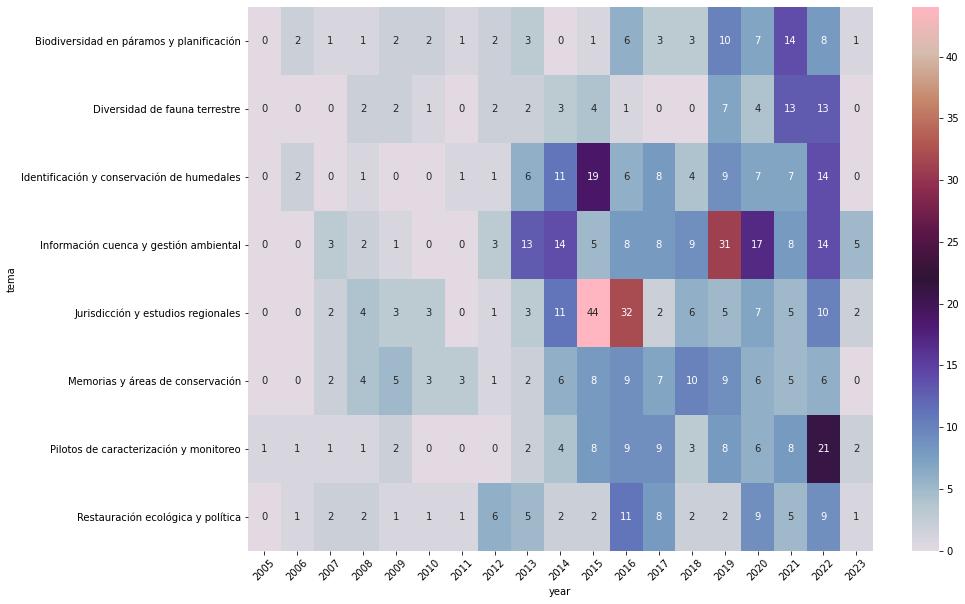

In [124]:
plt.figure(figsize=(14, 10))
sns.heatmap(pivot, cmap=paleta, annot=True, fmt='g')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.savefig(ruta_carpeta+"/8_HEAT_LDA_NIVELES.jpeg", dpi=300, bbox_inches='tight')

plt.show()

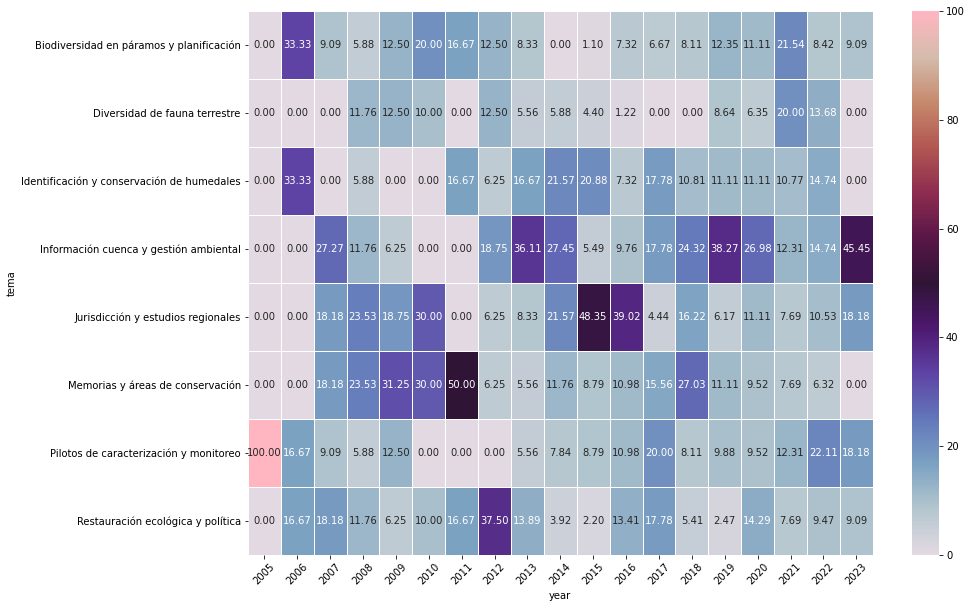

In [125]:
# Calcula el total de documentos por año
total_documentos_por_año = pivot.sum(axis=0)

# Calcula el porcentaje que representa cada tema por año
pivot_porcentaje = pivot.divide(total_documentos_por_año, axis=1) * 100

# Ahora, genera el heatmap con estos porcentajes
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_porcentaje, cmap=paleta, annot=True, fmt='.2f', linewidths=.5)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.savefig(ruta_carpeta+"/9_HEAT_LDA_PORCENTAJE_AÑO.jpeg", dpi=300, bbox_inches='tight')

plt.show()


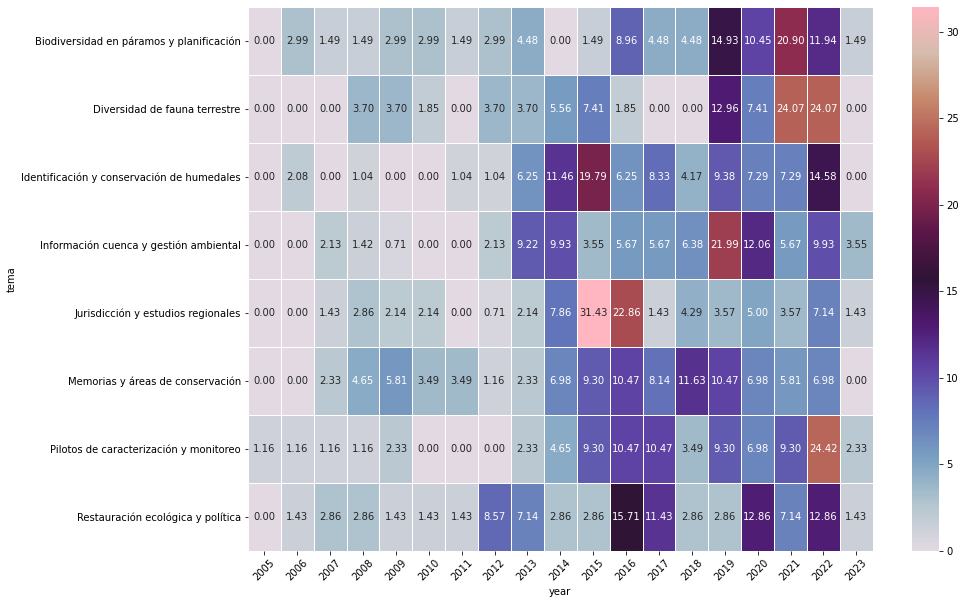

In [126]:
# Calcula el total de documentos por año
total_documentos_por_año = pivot.sum(axis=1)

# Calcula el porcentaje que representa cada tema por año
pivot_porcentaje = pivot.divide(total_documentos_por_año, axis=0) * 100

# Ahora, genera el heatmap con estos porcentajes
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_porcentaje, cmap=paleta, annot=True, fmt='.2f', linewidths=.5)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.savefig(ruta_carpeta+"/10_HEAT_LDA_PORCENTAJE_VARIABLE.jpeg", dpi=300, bbox_inches='tight')


plt.show()